## [How to add human-in-the-loop processes to the prebuilt ReAct agent](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent-hitl/)

In [3]:
!pip install -qU langchain langsmith langchain-core langchain-community langchain-experimental langchain-openai langchain-groq pypdf langchain-text-splitters langchain-chroma faiss-cpu sentence_transformers google-search-results wikipedia duckduckgo-search arxiv langgraph yfinance

# Load Envs

In [4]:
import os
from google.colab import userdata
# os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# os.environ['HUGGINGFACEHUB_API_TOKEN'] = userdata.get('HUGGINGFACEHUB_API_TOKEN')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
# os.environ['SERPAPI_API_KEY'] = userdata.get('SERPAPI_API_KEY')

# Setup Langsmith

In [5]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "langgraph_learning"

# LLM

In [179]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()

# Building Bot

In [180]:
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [181]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
import operator

# Parent Class
class State(MessagesState):
  messages: Annotated[Sequence[BaseMessage], operator.add]

## Tools

In [182]:
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()


from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [183]:
from langchain_core.tools import tool

@tool
def search_tool(user_input: str) -> str:
  """
  Search the web to provide answer to real time user query.

  Args:
    user_input: str

  Returns:
    Answer to the user query : str
  """
  return search.invoke(user_input)

@tool
def wikipedia_tool(user_input: str) -> str:
  """
  Use wikipedia to provide answer to historic user query.

  Args:
    user_input: str

  Returns:
    Answer to the user query : str
  """
  return wikipedia.invoke(user_input)

In [184]:
tools = [search_tool, wikipedia_tool]

### Bind Tool

In [185]:
llm_with_tools = llm.bind_tools(tools)

### Tool Node

In [186]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)

## Agent

In [187]:
def agentic_func(state: State):
  print("------------ Tool Calling Func ----------")
  print("state: ", state)

  query = state['messages']

  result = llm_with_tools.invoke(query)

  return {"messages" : [result]}

# Build Graph

In [188]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition

In [189]:
# 1. Create Instance of the Graph
workflow = StateGraph(State)


# 2. Create Nodes
workflow.add_node("Agent", agentic_func)
workflow.add_node("tools", tool_node) # this node should be named as tools


# 3. Create Conditional Edges
workflow.add_conditional_edges(
    "Agent",   # Tool Calling
    tools_condition, # Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.

)

## Create Cyclic Edge
workflow.add_edge("tools", "Agent")

## Create Entry Point
workflow.add_edge(START, "Agent")


# 4. Compile the Graph
my_graph = workflow.compile(
    checkpointer=memory,
    interrupt_before=["tools"]) # add memory here , human in loop here

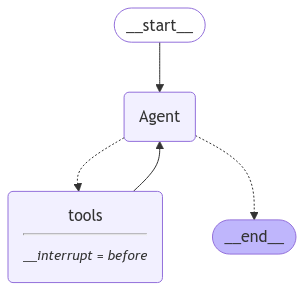

In [190]:
# 5. Display the graph
from IPython.display import Image, display

try:
    display(Image(my_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

# Run Graph

In [191]:
config = {"configurable": {"thread_id": "1"}}

In [192]:
def print_stream(stream):
    """A utility to pretty print the stream."""
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [193]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [("user", "what is the weather in SF, CA?")]}

print_stream(my_graph.stream(inputs, config, stream_mode="values"))


('user', 'what is the weather in SF, CA?')
------------ Tool Calling Func ----------
state:  {'messages': [('user', 'what is the weather in SF, CA?')]}
================================== Ai Message ==================================
Tool Calls:
  search_tool (call_KyOygUchRzHldWU2Rl2ItjpH)
 Call ID: call_KyOygUchRzHldWU2Rl2ItjpH
  Args:
    user_input: weather in San Francisco, CA


# Responses

# It stops and waits for Human to Respond

We can verify with `get_state` and `snapshot.next` -> the tool that will called next

In [194]:
snapshot = my_graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [['user', 'what is the weather in SF, CA?'], AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KyOygUchRzHldWU2Rl2ItjpH', 'function': {'arguments': '{"user_input":"weather in San Francisco, CA"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 132, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fdad4c22-1aa6-47de-95fe-011e6d34fe9e-0', tool_calls=[{'name': 'search_tool', 'args': {'user_input': 'weather in San Francisco, CA'}, 'id': 'call_KyOygUchRzHldWU2Rl2ItjpH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 21, 't

In [195]:
print("Next step: ", snapshot.next)

Next step:  ('tools',)


In [196]:
last_message=snapshot.values["messages"][-1]
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KyOygUchRzHldWU2Rl2ItjpH', 'function': {'arguments': '{"user_input":"weather in San Francisco, CA"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 132, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fdad4c22-1aa6-47de-95fe-011e6d34fe9e-0', tool_calls=[{'name': 'search_tool', 'args': {'user_input': 'weather in San Francisco, CA'}, 'id': 'call_KyOygUchRzHldWU2Rl2ItjpH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 21, 'total_tokens': 153, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outpu

In [197]:
last_message.tool_calls # This was what we implemented from scratch in the previous notebook

[{'name': 'search_tool',
  'args': {'user_input': 'weather in San Francisco, CA'},
  'id': 'call_KyOygUchRzHldWU2Rl2ItjpH',
  'type': 'tool_call'}]

## 1. Now to provide response

In [198]:
print_stream(my_graph.stream(None, config, stream_mode="values"))

================================== Ai Message ==================================
Tool Calls:
  search_tool (call_KyOygUchRzHldWU2Rl2ItjpH)
 Call ID: call_KyOygUchRzHldWU2Rl2ItjpH
  Args:
    user_input: weather in San Francisco, CA
================================= Tool Message =================================
Name: search_tool

San Francisco Weather Forecasts. Weather Underground provides local & long-range weather forecasts, weatherreports, maps & tropical weather conditions for the San Francisco area. Local Forecast Office More Local Wx 3 Day History Hourly Weather Forecast. Extended Forecast for San Francisco CA . Overnight. Low: 49 °F. Mostly Cloudy. Monday. High: 58 °F. Decreasing Clouds. Monday Night. Low: 48 °F. ... San Francisco CA 37.74°N 122.46°W (Elev. 610 ft) Last Update: 12:26 am PST Jan 6, 2025. Forecast Valid: 1am PST Jan 6 ... Local Forecast Office More Local Wx 3 Day History Hourly Weather Forecast. Extended Forecast for San Francisco CA . Tonight. Low: 49 °F. Patchy

## 2. We can also edit the question in between

In [199]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [("user", "what is the weather in SF, CA?")]}

print_stream(my_graph.stream(inputs, config, stream_mode="values"))

('user', 'what is the weather in SF, CA?')
------------ Tool Calling Func ----------
state:  {'messages': [['user', 'what is the weather in SF, CA?'], AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KyOygUchRzHldWU2Rl2ItjpH', 'function': {'arguments': '{"user_input":"weather in San Francisco, CA"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 132, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fdad4c22-1aa6-47de-95fe-011e6d34fe9e-0', tool_calls=[{'name': 'search_tool', 'args': {'user_input': 'weather in San Francisco, CA'}, 'id': 'call_KyOygUchRzHldWU2Rl2ItjpH', 'type': 'to

In [200]:
snapshot = my_graph.get_state(config)

In [201]:
last_message=snapshot.values["messages"][-1]

In [202]:
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2cZpAQUwLPLZnSHze88CIHdb', 'function': {'arguments': '{"user_input":"weather in San Francisco, CA"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 610, 'total_tokens': 631, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2e8d8aa0-3e62-4f45-8297-88352e08de65-0', tool_calls=[{'name': 'search_tool', 'args': {'user_input': 'weather in San Francisco, CA'}, 'id': 'call_2cZpAQUwLPLZnSHze88CIHdb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 610, 'output_tokens': 21, 'total_tokens': 631, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outpu

In [204]:
last_message.tool_calls

[{'name': 'search_tool',
  'args': {'user_input': 'weather in San Francisco, CA'},
  'id': 'call_2cZpAQUwLPLZnSHze88CIHdb',
  'type': 'tool_call'}]

In [205]:
last_message.tool_calls[-1]['args'] = {'user_input': 'weather in michigan'}

In [206]:
last_message.tool_calls

[{'name': 'search_tool',
  'args': {'user_input': 'weather in michigan'},
  'id': 'call_2cZpAQUwLPLZnSHze88CIHdb',
  'type': 'tool_call'}]

In [207]:
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2cZpAQUwLPLZnSHze88CIHdb', 'function': {'arguments': '{"user_input":"weather in San Francisco, CA"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 610, 'total_tokens': 631, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2e8d8aa0-3e62-4f45-8297-88352e08de65-0', tool_calls=[{'name': 'search_tool', 'args': {'user_input': 'weather in michigan'}, 'id': 'call_2cZpAQUwLPLZnSHze88CIHdb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 610, 'output_tokens': 21, 'total_tokens': 631, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_d

In [208]:
tool_call_id = last_message.tool_calls[-1]["id"]
tool_call_id # Make sure to add the tool id

'call_2cZpAQUwLPLZnSHze88CIHdb'

In [209]:
from langchain_core.messages import AIMessage, ToolMessage

In [211]:
new_messages = [
    ToolMessage(content='', tool_call_id=tool_call_id),
    last_message,
]

In [212]:
my_graph.update_state(config, {"messages": new_messages})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcca49-8b87-6f50-8007-74150ef68046'}}

In [213]:
print_stream(my_graph.stream(None, config, stream_mode="values"))

================================== Ai Message ==================================
Tool Calls:
  search_tool (call_2cZpAQUwLPLZnSHze88CIHdb)
 Call ID: call_2cZpAQUwLPLZnSHze88CIHdb
  Args:
    user_input: weather in michigan
================================= Tool Message =================================
Name: search_tool

NOAA National Weather Service. Cloudy, with a low around 21. Calm wind becoming north northeast around 6 mph after midnight. For More Weather Information: Grand Rapids, MI Local Forecast Office. 24NM W Ludington MI Marine Point Forecast. This Afternoon. High: 30 °F. WNW 17kt 3ft. Tonight. Low: 26 °F. NW 22kt 3-5ft. Friday. High: 28 °F. NW 23kt 5-6ft. Friday Night. In Michigan, for the rest of the night, the weather will be cloudy. The lowest anticipated temperature is a subzero 15.8°F (-9°C). Sunrise was at 8:15 am and sunset at 5:21 pm; the daylight lasted for 9h and 7min. Snow in West Michigan and Northern Lower Michigan. Several inches of accumulation is possible fo

## 3. You can edit the ai response in between

In [214]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [("user", "what is the weather in SF, CA?")]}

print_stream(my_graph.stream(inputs, config, stream_mode="values"))

('user', 'what is the weather in SF, CA?')
------------ Tool Calling Func ----------
state:  {'messages': [['user', 'what is the weather in SF, CA?'], AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KyOygUchRzHldWU2Rl2ItjpH', 'function': {'arguments': '{"user_input":"weather in San Francisco, CA"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 132, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fdad4c22-1aa6-47de-95fe-011e6d34fe9e-0', tool_calls=[{'name': 'search_tool', 'args': {'user_input': 'weather in San Francisco, CA'}, 'id': 'call_KyOygUchRzHldWU2Rl2ItjpH', 'type': 'to

In [215]:
snapshot = my_graph.get_state(config)

In [216]:
last_message=snapshot.values["messages"][-1]

In [217]:
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Blb4KN5XyD4g7Glo3bMBjdfv', 'function': {'arguments': '{"user_input":"weather in San Francisco, CA"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 1036, 'total_tokens': 1057, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c0cd72ad-c546-4649-a8a8-9fd8c9b79221-0', tool_calls=[{'name': 'search_tool', 'args': {'user_input': 'weather in San Francisco, CA'}, 'id': 'call_Blb4KN5XyD4g7Glo3bMBjdfv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1036, 'output_tokens': 21, 'total_tokens': 1057, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'o

In [218]:
tool_call_id = last_message.tool_calls[-1]["id"]
tool_call_id # Make sure to add the tool id

'call_Blb4KN5XyD4g7Glo3bMBjdfv'

In [219]:
from langchain_core.messages import AIMessage, ToolMessage
answer = "I recide in MI, i dono about SF"

In [220]:
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [221]:
my_graph.update_state(config, {"messages": new_messages})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcca53-3de6-642f-800d-1389fc40aeda'}}

In [222]:
print_stream(my_graph.stream(None, config, stream_mode="values"))

================================== Ai Message ==================================

I recide in MI, i dono about SF
